In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class NeuralNetwork(torch.nn.Module):

    def __init__(self, n_inputs: int, n_layers: int, n_neurons: int, n_output: int, act):
        super().__init__()

        self.n_inputs = n_inputs 
        self.n_layers = n_layers
        self.n_neurons = n_neurons

        layers = []

        layers.append( torch.nn.Linear(n_inputs, n_neurons))
        for i in range(n_layers): layers.extend( [torch.nn.Linear(n_neurons,n_neurons), act])
        layers.append(torch.nn.Linear(n_neurons, n_output))

        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze() 

### Problema: Equação do calor com condição de contorno de Dirichlet\n

O problema proposto é dado por:

$$
\dfrac{\partial u}{\partial t} = \alpha \dfrac{\partial^2 u}{\partial x^2}, \hspace{0.5cm} x \in [-1, 1], t \in [0, 1]
$$

onde as condições de contorno são dadas por $u(-1, t) = u(1, t) = 0$ e $u(x, 0) =  \sin(\dfrac{n \pi x}{L})$.

Tomaremos $\alpha = 0.4, L = 1$ e $n = 1$. A solução exata é dada por $u(x,t) = e^{\dfrac{-n^2 \pi^2 \alpha t}{L^2}} \sin(\dfrac{n \pi x}{L})$.



In [3]:
# ARQUITETURA DA REDE
MODEL = NeuralNetwork(2, 3, 60, 1, torch.nn.Tanh())
MODEL = torch.jit.script(MODEL)


# DOMÍNIO ESPACIAL E TEMPORAL
X = torch.FloatTensor(100).uniform_(-1, 1).requires_grad_()
T = torch.FloatTensor(100).uniform_(0, 1).requires_grad_()

# VARIAVEIS CONDIÇÃO INICIAL E DE CONTORNO
IC = torch.cartesian_prod(X, torch.tensor([0.]))
X0 = torch.cartesian_prod(torch.tensor([-1.]), T)
X1 = torch.cartesian_prod(torch.tensor([1.]), T)

# PARÂMETROS DA EQUAÇÃO
N = 1
L = 1
ALPHA = 0.4

In [4]:
# DEFINIÇÃO DA EQUAÇÃO RESIDUAL
def f(x): 
    return torch.pi**2 * torch.sin(torch.pi * x)

def residuo(x, t, model):

    input = torch.stack((x,t),1)

    u = model(input)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    return u_t - ALPHA * u_xx

def loss_fn(model):

    # PERDA DA EQUAÇÃO RESIDUAL
    out_res = residuo(X, T, model)
    l_res = torch.mean(torch.square(out_res))

    # PERDA PARA OS VALORES DE CONTORNO
    out_cont1 = model(X0)
    out_cont2 = model(X1)
    l_cont1 = torch.mean(torch.square(out_cont1))
    l_cont2 = torch.mean(torch.square(out_cont2))

    # PERDA CONDIÇÃO INICIAL
    out_ic = model(IC)
    l_ic = torch.mean(torch.square(out_ic - torch.sin((N * torch.pi * X) / L)))

    # PERDA TOTAL
    loss = l_res + l_cont1 + l_cont2 + l_ic
    return loss 

# PARÂMETROS DO TREINAMENTO 
optmizer = torch.optim.Adam(MODEL.parameters(), lr= 1e-3)

# LOOP DE TREINAMENTO
loss_history = []
for ep in range(5000):

    optmizer.zero_grad()

    loss = loss_fn(MODEL)
    loss_history.append(loss.item())

    with torch.autograd.no_grad():
        if ep % 1000 == 0:
            print(f'Epochs: {ep} Loss: {loss.item()}')

    loss.backward(retain_graph = True)
    optmizer.step()

Epochs: 0 Loss: 0.5100780725479126
Epochs: 1000 Loss: 0.00042345697875134647
Epochs: 2000 Loss: 0.009354926645755768
Epochs: 3000 Loss: 2.6917343348031864e-05
Epochs: 4000 Loss: 5.273845818010159e-05


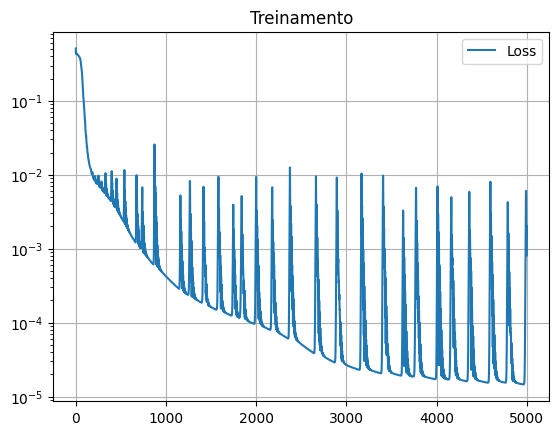

In [5]:
plt.plot(loss_history, label = 'Loss')
plt.title('Treinamento')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

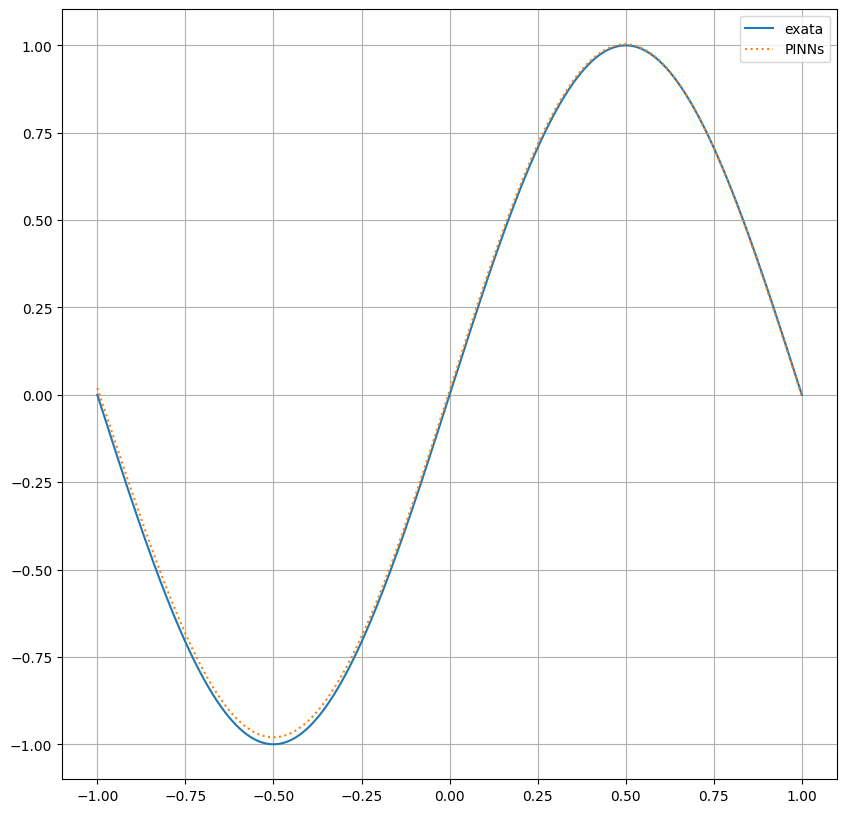

In [6]:
size = 1000
x_test = torch.linspace(-1., 1., size)
t_test = torch.tensor([0.0])
input = torch.cartesian_prod(x_test, t_test)
out = MODEL(input)

def exata(x, t): return torch.exp(-(N**2 * torch.pi**2 * ALPHA * t[:])/ L**2 ) * torch.sin((N*torch.pi * x[:])/L)
out_exata = exata(x_test, t_test)

x_test = x_test.detach().numpy()
out = out.detach().numpy()
out_exata = out_exata.detach().numpy()

#PLOTAGEM
plt.figure(figsize=(10, 10))
plt.plot(x_test, out_exata, label = 'exata')
plt.plot(x_test, out, label = 'PINNs', linestyle = 'dotted')
plt.grid()
plt.legend()
plt.show()

Text(0.5, 1.0, 'Equação do calor')

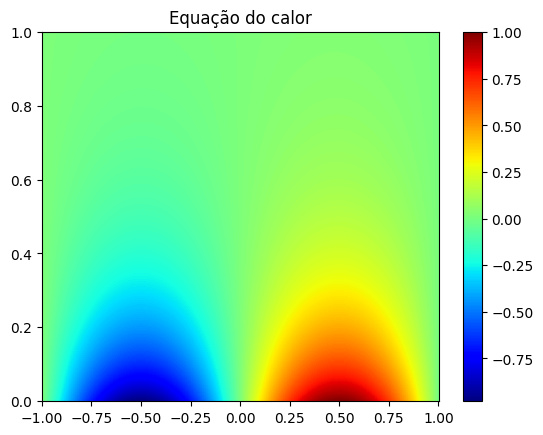

In [7]:
SIZE = 1000
x_test = torch.linspace(-1., 1., SIZE)
t_test = torch.linspace(0., 1., SIZE)
input = torch.cartesian_prod(x_test, t_test)
out = MODEL(input)

x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
out = out.detach().numpy()
#out_exata = out_exata.detach().numpy()

out = out.reshape(1000, 1000).T
plt.pcolormesh(x_test, t_test, out, cmap = 'jet')
plt.colorbar()
plt.title('Equação do calor')